In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import pickle
import keras
from matplotlib import pyplot

In [2]:
def downside_risk(returns, risk_free=4):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside) * 252)


def sortino(returns, risk_free=4):
    adj_returns = returns - risk_free
    drisk = downside_risk(adj_returns)

    if drisk == 0:
        return np.nan

    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / drisk

In [26]:
#import data
gdx = pd.read_csv('GDX.csv').drop('Adj Close', axis=1).interpolate(method='linear')
gdx['Date'] = pd.to_datetime(gdx['Date'])

sp500 = pd.read_csv('SPY.csv').drop(['Adj Close', 'Low', 'High', 'Open', 'Volume'], axis=1)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.columns = ['Date', 'SP500']

gold = pd.read_csv('gold.csv').iloc[::-1].reset_index().drop('index', axis=1)
gold = gold[gold['Close*'] != '-']
# convert date to datetime
gold['Date'] = pd.to_datetime(gold['Date'])

#merge data
merged = pd.merge(gdx, gold, on='Date')
data = pd.merge(merged, sp500, on='Date').drop('Date', axis=1).interpolate(method='linear')
data.columns = ['GDX open', 'GDX high', 'GDX low', 'GDX close', 'GDX volume', 'Gold close', 'SP500']
data['GDX volume'] = data['GDX volume'].astype(float)
data['Gold close'] = data['Gold close'].str.replace(',', '')
data['Gold close'] = data['Gold close'].astype(float)

data['GDX hist'] = np.nan
data['Diff'] = np.nan
data['Volatility'] = np.nan

ran = 200

for i in range(ran-1, len(data['GDX close'])):
    data['GDX hist'][i] = data['GDX close'][(i-ran):i].mean()
    data['Volatility'][i] = data['GDX close'][(i-ran):i].std()**2

data['Diff'] = (data['GDX close'] - data['GDX hist']) * data['Volatility']

data['y']= data['GDX close'].shift(-1)

data.dropna(inplace=True)

saved = data['SP500'].copy()

X = data.drop(['y'], axis=1)
X = MinMaxScaler().fit_transform(X)

Y = data['y']


validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

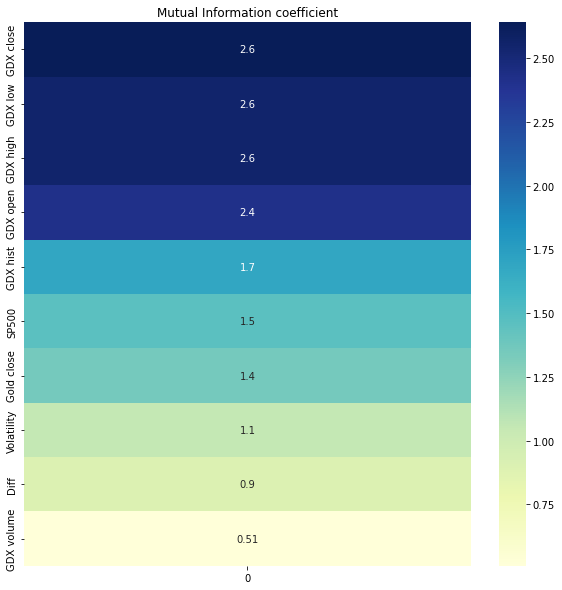

In [4]:
opt1 = 1

if opt1 == 1:
    mi = pd.DataFrame()
    for i in data.columns:
        if i != 'y':
            mi[i] = mutual_info_regression(pd.array(data[i]).reshape(-1, 1), data['y'])

    mi = mi.transpose()
    mi.sort_values(by=0, inplace=True)

    #sort mi
    mi = mi.sort_values(by=0, ascending=False)

    # plot mi
    plt.figure(figsize=(10,10))
    plt.title('Mutual Information coefficient')
    sns.heatmap(mi, annot=True, cmap="YlGnBu")
    plt.show()

In [5]:
x_total = np.append(X_train, X_test, axis=0)
y_total = np.append(Y_train, Y_test, axis=0)

# import xgb model
xgb_model = pickle.load(open('xgb_model.sav', 'rb'))
#import linear model
linear_model = pickle.load(open('linear_model.sav', 'rb'))
#import ann model
ann_model = keras.models.load_model('ann_model.h5')

# predict xgb
pred_xgb = xgb_model.predict(x_total)
# predict linear
pred_linear = linear_model.predict(x_total)
# predict ann
pred_ann = ann_model.predict(x_total)

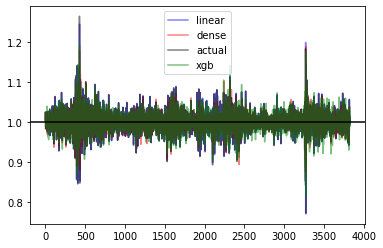

ANN error: 0.02509498806610228
Linear error: 0.027750143093699824
XGB error: 0.02513506664396077


In [6]:
pred1 = pred_ann
pred_dense = list()

for i in range(len(pred1)):
    pred_dense.append(pred1[i][0])

y_total = y_total/np.roll(y_total, 1)
pred_dense = pred_dense/np.roll(pred_dense, 1)
pred_linear = pred_linear/np.roll(pred_linear, 1)
pred_xgb = pred_xgb/np.roll(pred_xgb, 1)


y_total = y_total[1:]
pred_dense = pred_dense[1:]
pred_linear = pred_linear[1:]
pred_xgb = pred_xgb[1:]

skip = 1
# moving average of prediction
pred_dense = np.convolve(pred_dense, np.ones((skip,))/skip, mode='valid')
# moving average of actual
y_total = np.convolve(y_total, np.ones((skip,))/skip, mode='valid')
# moving average of linear
pred_linear = np.convolve(pred_linear, np.ones((skip,))/skip, mode='valid')

pyplot.plot(pred_linear, color='b',  label='linear', alpha=0.5)
pyplot.plot(pred_dense, color='r', label='dense', alpha=0.5)
pyplot.plot(y_total, color='k', label='actual', alpha=0.5)
pyplot.plot(pred_xgb, color='g', label='xgb', alpha=0.5)
pyplot.axhline(y=1, color='black', linestyle='-')
pyplot.legend()
pyplot.show()

#print the mape
print('ANN error:', np.mean(np.abs((pred_dense-y_total)/y_total)))
print('Linear error:', np.mean(np.abs((pred_linear-y_total)/y_total)))
print('XGB error:', np.mean(np.abs((pred_xgb-y_total)/y_total)))

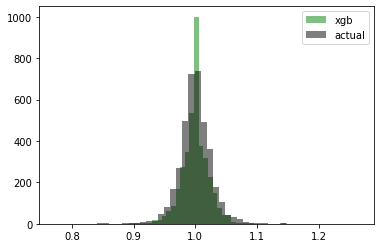

In [7]:
# plot histogram of prediction
#plt.hist(pred_dense, bins=50, color='r', alpha=0.5, label='dense')
#plt.hist(pred_linear, bins=50, color='b', alpha=0.5, label='linear')
plt.hist(pred_xgb, bins=50, color='g', alpha=0.5, label='xgb')
plt.hist(y_total, bins=50, color='k', alpha=0.5, label='actual')
plt.legend()
plt.show()

In [ ]:
# 1 if prediction is greater than 1

# change minimum and maximum to maximize Sharpe
minimum = 1.008
maximum = .985

fee = 2
alavancagem = 1
c0 = 1000
c1 = 1
opt = 1

predF = list()

if opt == 1:
    for i in range(0, len(pred_dense)):
        if (pred_xgb[i] > minimum):
            predF.append(1)
        elif (pred_xgb[i] < maximum):
            predF.append(-1)
        else:
            predF.append(0)
else:
    predF = (0.3*pred_dense+0.1*pred_linear+.6*pred_xgb)
    for i in range(0, len(predF)):
        if predF[i] > minimum:
            predF[i] = 1
        elif predF[i] < maximum:
            predF[i] = -1
        else:
            predF[i] = 0

predF = predF*(y_total-1)

port = list()
port.append(predF[0]+c0)
for i in range(1, len(predF)):
    calc = port[i-1]+alavancagem*port[i-1]*(predF[i])+c1-fee
    if calc > 0:
        port.append(calc)
    else:
        port.append(0)

#plot port
pyplot.plot(port, label='port')
pyplot.axhline(y=c0, color='black', linestyle='-')
pyplot.legend()
pyplot.show()

print('Rendimento {:.2f}%'.format((port[-1]*100/c0)-100))
print('R${:.2f} final com R${:.1f} de investimento inicial e R${:.1f} de investimento diário ao longo de {:d} anos e {:.0f} dias'.format(port[-1], c0, c1, (len(port)//365), (len(port)/365-(len(port)//365))*365))
print('Sharpe =', (port[-1]-(1.04**(len(predF)/365)))/np.std(port))
print('Sortino =', sortino(pd.array(port)))

In [28]:
sp500

,Date,SP500
0,2006-05-22,126.129997
1,2006-05-23,125.169998
2,2006-05-24,126.169998
3,2006-05-25,127.730003
4,2006-05-26,128.380005
...,...,...
4029,2022-05-23,396.920013
4030,2022-05-24,393.890015
4031,2022-05-25,397.369995
4032,2022-05-26,405.309998
